# ResNet34

## 這裡為ResNet34的訓練結果及過程，詳細的結果以及討論會在Pdf報告中與其他Model呈現。

## Library 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import time

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense, AveragePooling2D,GlobalAveragePooling2D, Input
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.layers.merge import concatenate
from keras.models import Model
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Model,load_model
#VIS
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import load_model #Tensorflow 2.0

## Data Preprocessing

In [ ]:
def Data_process(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (150,150,3)
    -Read the directory name and asign as a class
    '''
    X = []
    y = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv = cv2.cvtColor(img_cv,cv2.COLOR_BGR2RGB)
                img_cv_r = cv2.resize(img_cv,(150,150))
                X.append(img_cv_r)
                y.append(int(directory.split("/")[-1].replace('c','')))    

    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2)

    return np.array(X_train), np.array(X_test) ,np.array(y_train), np.array(y_test)

In [ ]:
#Paths
train_data_path = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
test_data_path =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_train, X_test , y_train, y_test= Data_process(train_data_path)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (17939, 150, 150, 3)
y_train shape: (17939,)
X_test shape: (4485, 150, 150, 3)
y_test shape: (4485,)


In [ ]:
y_train_one = keras.utils.to_categorical(y_train,10)
y_test_one = keras.utils.to_categorical(y_test,10)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train_one.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test_one.shape)

X_train shape: (17939, 150, 150, 3)
y_train shape: (17939, 10)
X_test shape: (4485, 150, 150, 3)
y_test shape: (4485, 10)


## Data Observation

There are  [0 1 2 3 4 5 6 7 8 9] different labels in this dataset.
Labels count in y_train: [1979 1815 1860 1880 1853 1870 1858 1588 1539 1697]
Labels count in y_test: [510 452 457 466 473 442 467 414 372 432] 

Showing some examples of different labels



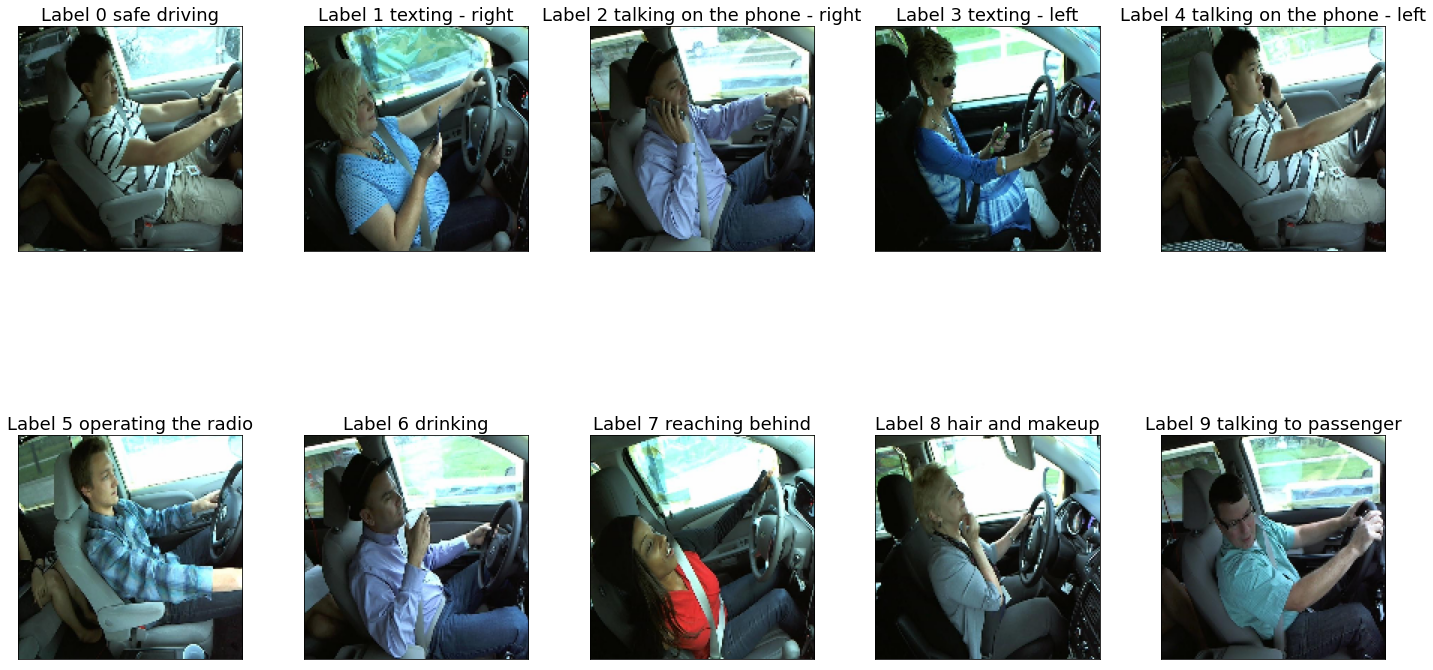

In [ ]:
print("There are ",np.unique(y_train),"different labels in this dataset.")
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test),'\n')

label = {"mask_name":[],"data":[]}
for i in np.unique(y_train):
    label["mask_name"].append("label " + str(i))
    label["data"].append(X_train[y_train==i,:])
    
labels=['safe driving','texting - right','talking on the phone - right'
        ,'texting - left','talking on the phone - left','operating the radio',
        'drinking','reaching behind','hair and makeup','talking to passenger']
print('Showing some examples of different labels\n')
#fig, axes = plt.subplots(2, 5, figsize = (5, 5))
fig = plt.figure(figsize = (20, 20))
for i in np.unique(y_train):
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(label["data"][i][1])
  ax.set_title('Label '+str(i)+' '+str(labels[i]), fontsize = 18)
  plt.tight_layout()

## Building Model

## ResNet34

In [ ]:
def Conv2d_BN(layer, nb_filter,kernel_size, padding='same',strides=(1,1)):

    layer = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu')(layer)
    layer = BatchNormalization(axis=3)(layer)

    return layer

def Residual_Block(input_model,nb_filter,kernel_size,strides=(1,1), shortcut =False):
    layer= Conv2d_BN(input_model,nb_filter=nb_filter,kernel_size=kernel_size,strides=strides,padding='same')
    layer= Conv2d_BN(layer, nb_filter=nb_filter, kernel_size=kernel_size,padding='same')
    
    if shortcut:
        shortcut = Conv2d_BN(input_model,nb_filter=nb_filter,strides=strides,kernel_size=kernel_size)
        layer= layers.add([layer,shortcut])
        return layer
    else:
        layer= layers.add([layer,input_model])
        return layer
    
def ResNet34(width, height, depth, classes):
    
    Img = Input(shape=(width,height,depth))
    
    layer= Conv2d_BN(Img,64,(7,7),strides=(2,2),padding='same')
    layer= MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)  

    layer= Residual_Block(layer,nb_filter=64,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=64,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=64,kernel_size=(3,3))

    layer= Residual_Block(layer,nb_filter=128,kernel_size=(3,3),strides=(2,2),shortcut=True)
    layer= Residual_Block(layer,nb_filter=128,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=128,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=128,kernel_size=(3,3))

    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3),strides=(2,2),shortcut=True)
    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=256,kernel_size=(3,3))
    
    layer= Residual_Block(layer,nb_filter=512,kernel_size=(3,3),strides=(2,2),shortcut=True)
    layer= Residual_Block(layer,nb_filter=512,kernel_size=(3,3))
    layer= Residual_Block(layer,nb_filter=512,kernel_size=(3,3))

    layer= GlobalAveragePooling2D()(layer)
    layer= Dense(classes,activation='softmax')(layer)
    
    model=Model(inputs=Img,outputs=layer)
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 75, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 38, 38, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

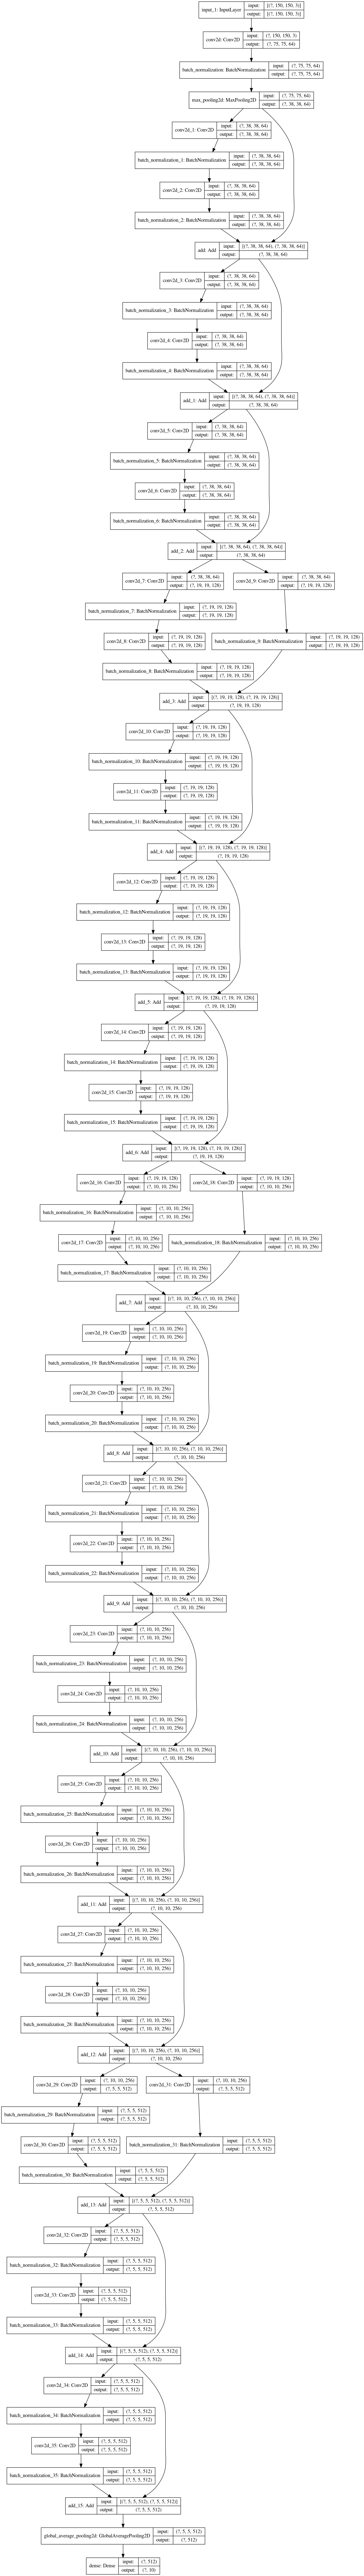

In [ ]:
ResNet34_model = ResNet34(150,150,3,10)
ResNet34_model.summary()
plot_model(ResNet34_model, show_shapes=True)

## Training ResNet34

Learning rate： 0.0001 & Batch size： 16
Epoch 1/10
897/897 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.8385
Epoch 00001: val_loss improved from inf to 0.13223, saving model to ResNet34_best_weight1.hdf5
897/897 [==============================] - 43s 48ms/step - loss: 0.5113 - accuracy: 0.8385 - val_loss: 0.1322 - val_accuracy: 0.9574
Epoch 2/10
896/897 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9699
Epoch 00002: val_loss improved from 0.13223 to 0.09200, saving model to ResNet34_best_weight1.hdf5
897/897 [==============================] - 42s 47ms/step - loss: 0.0965 - accuracy: 0.9700 - val_loss: 0.0920 - val_accuracy: 0.9727
Epoch 3/10
897/897 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9790
Epoch 00003: val_loss did not improve from 0.09200
897/897 [==============================] - 41s 46ms/step - loss: 0.0665 - accuracy: 0.9790 - val_loss: 0.2004 - val_accuracy: 0.9429
Epoch 4/10
896/897 [=========

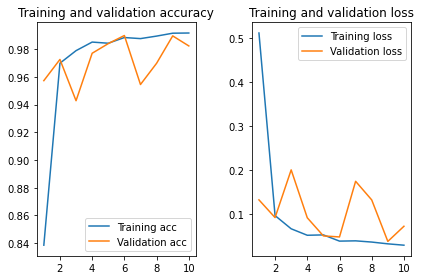

Learning rate： 0.0001 & Batch size： 32
Epoch 1/10
448/449 [============================>.] - ETA: 0s - loss: 0.5007 - accuracy: 0.8433
Epoch 00001: val_loss improved from inf to 0.26135, saving model to ResNet34_best_weight2.hdf5
449/449 [==============================] - 33s 73ms/step - loss: 0.5002 - accuracy: 0.8434 - val_loss: 0.2614 - val_accuracy: 0.9175
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9743
Epoch 00002: val_loss improved from 0.26135 to 0.18260, saving model to ResNet34_best_weight2.hdf5
449/449 [==============================] - 32s 71ms/step - loss: 0.0814 - accuracy: 0.9742 - val_loss: 0.1826 - val_accuracy: 0.9482
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9860
Epoch 00003: val_loss improved from 0.18260 to 0.11014, saving model to ResNet34_best_weight2.hdf5
449/449 [==============================] - 32s 71ms/step - loss: 0.0462 - accuracy: 0.9860 - val_loss: 0.1101 - va

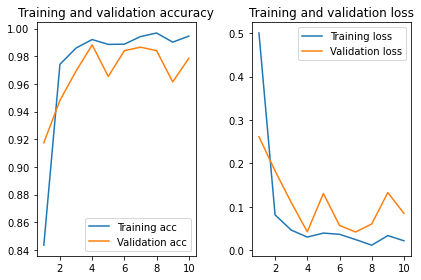

Learning rate： 0.0001 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.8327
Epoch 00001: val_loss improved from inf to 0.55233, saving model to ResNet34_best_weight3.hdf5
299/299 [==============================] - 30s 100ms/step - loss: 0.5434 - accuracy: 0.8327 - val_loss: 0.5523 - val_accuracy: 0.8258
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9825
Epoch 00002: val_loss improved from 0.55233 to 0.16487, saving model to ResNet34_best_weight3.hdf5
299/299 [==============================] - 29s 97ms/step - loss: 0.0564 - accuracy: 0.9825 - val_loss: 0.1649 - val_accuracy: 0.9501
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9822
Epoch 00003: val_loss did not improve from 0.16487
299/299 [==============================] - 28s 94ms/step - loss: 0.0547 - accuracy: 0.9822 - val_loss: 0.1740 - val_accuracy: 0.9529
Epoch 4/10
299/299 [========

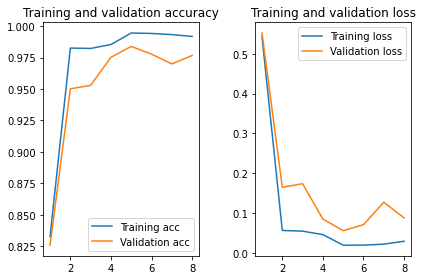

Learning rate： 0.0005 & Batch size： 16
Epoch 1/10
897/897 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.8480
Epoch 00001: val_loss improved from inf to 0.19944, saving model to ResNet34_best_weight4.hdf5
897/897 [==============================] - 43s 48ms/step - loss: 0.4906 - accuracy: 0.8480 - val_loss: 0.1994 - val_accuracy: 0.9409
Epoch 2/10
897/897 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9653
Epoch 00002: val_loss did not improve from 0.19944
897/897 [==============================] - 42s 47ms/step - loss: 0.1192 - accuracy: 0.9653 - val_loss: 0.2164 - val_accuracy: 0.9328
Epoch 3/10
897/897 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9746
Epoch 00003: val_loss did not improve from 0.19944
897/897 [==============================] - 41s 46ms/step - loss: 0.0827 - accuracy: 0.9746 - val_loss: 0.2615 - val_accuracy: 0.9225
Epoch 4/10
897/897 [==============================] - ETA: 0s - loss: 0.0723 

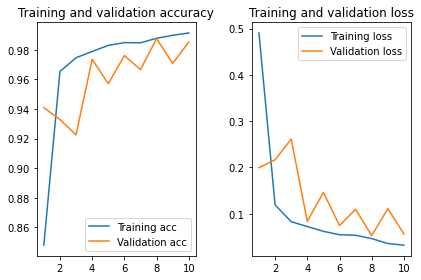

Learning rate： 0.0005 & Batch size： 32
Epoch 1/10
448/449 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.8588
Epoch 00001: val_loss improved from inf to 0.28400, saving model to ResNet34_best_weight5.hdf5
449/449 [==============================] - 32s 72ms/step - loss: 0.4629 - accuracy: 0.8588 - val_loss: 0.2840 - val_accuracy: 0.9192
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9755
Epoch 00002: val_loss did not improve from 0.28400
449/449 [==============================] - 31s 69ms/step - loss: 0.0849 - accuracy: 0.9755 - val_loss: 0.3740 - val_accuracy: 0.9033
Epoch 3/10
448/449 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9842
Epoch 00003: val_loss did not improve from 0.28400
449/449 [==============================] - 31s 68ms/step - loss: 0.0548 - accuracy: 0.9842 - val_loss: 0.3008 - val_accuracy: 0.9066
Epoch 4/10
448/449 [============================>.] - ETA: 0s - loss: 0.0408 

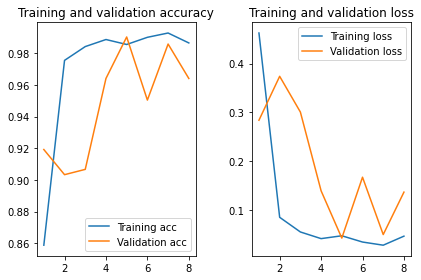

Learning rate： 0.0005 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8551
Epoch 00001: val_loss improved from inf to 0.40423, saving model to ResNet34_best_weight6.hdf5
299/299 [==============================] - 29s 98ms/step - loss: 0.4909 - accuracy: 0.8551 - val_loss: 0.4042 - val_accuracy: 0.8910
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9771
Epoch 00002: val_loss improved from 0.40423 to 0.13215, saving model to ResNet34_best_weight6.hdf5
299/299 [==============================] - 29s 97ms/step - loss: 0.0793 - accuracy: 0.9771 - val_loss: 0.1322 - val_accuracy: 0.9601
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9885
Epoch 00003: val_loss did not improve from 0.13215
299/299 [==============================] - 28s 92ms/step - loss: 0.0436 - accuracy: 0.9885 - val_loss: 0.1775 - val_accuracy: 0.9451
Epoch 4/10
299/299 [=========

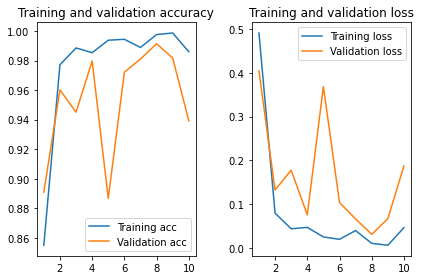

Learning rate： 0.001 & Batch size： 16
Epoch 1/10
896/897 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.7942
Epoch 00001: val_loss improved from inf to 0.40057, saving model to ResNet34_best_weight7.hdf5
897/897 [==============================] - 43s 48ms/step - loss: 0.6677 - accuracy: 0.7942 - val_loss: 0.4006 - val_accuracy: 0.8793
Epoch 2/10
896/897 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9576
Epoch 00002: val_loss did not improve from 0.40057
897/897 [==============================] - 41s 46ms/step - loss: 0.1415 - accuracy: 0.9576 - val_loss: 1.4157 - val_accuracy: 0.6399
Epoch 3/10
896/897 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9714
Epoch 00003: val_loss improved from 0.40057 to 0.08858, saving model to ResNet34_best_weight7.hdf5
897/897 [==============================] - 42s 47ms/step - loss: 0.0957 - accuracy: 0.9714 - val_loss: 0.0886 - val_accuracy: 0.9738
Epoch 4/10
896/897 [==========

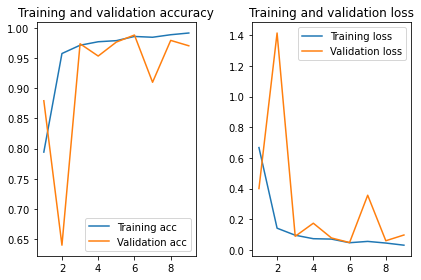

Learning rate： 0.001 & Batch size： 32
Epoch 1/10
448/449 [============================>.] - ETA: 0s - loss: 0.6163 - accuracy: 0.8191
Epoch 00001: val_loss improved from inf to 1.15266, saving model to ResNet34_best_weight8.hdf5
449/449 [==============================] - 32s 72ms/step - loss: 0.6159 - accuracy: 0.8190 - val_loss: 1.1527 - val_accuracy: 0.7216
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9683
Epoch 00002: val_loss improved from 1.15266 to 0.26626, saving model to ResNet34_best_weight8.hdf5
449/449 [==============================] - 32s 70ms/step - loss: 0.1036 - accuracy: 0.9684 - val_loss: 0.2663 - val_accuracy: 0.9284
Epoch 3/10
448/449 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9791
Epoch 00003: val_loss improved from 0.26626 to 0.24946, saving model to ResNet34_best_weight8.hdf5
449/449 [==============================] - 32s 70ms/step - loss: 0.0702 - accuracy: 0.9791 - val_loss: 0.2495 - val

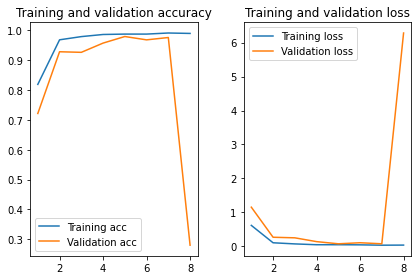

Learning rate： 0.001 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.8070
Epoch 00001: val_loss improved from inf to 0.32662, saving model to ResNet34_best_weight9.hdf5
299/299 [==============================] - 30s 100ms/step - loss: 0.6800 - accuracy: 0.8070 - val_loss: 0.3266 - val_accuracy: 0.8955
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9709
Epoch 00002: val_loss did not improve from 0.32662
299/299 [==============================] - 28s 93ms/step - loss: 0.0937 - accuracy: 0.9709 - val_loss: 0.9448 - val_accuracy: 0.8002
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9829
Epoch 00003: val_loss did not improve from 0.32662
299/299 [==============================] - 28s 93ms/step - loss: 0.0594 - accuracy: 0.9829 - val_loss: 0.3300 - val_accuracy: 0.9027
Epoch 4/10
299/299 [==============================] - ETA: 0s - loss: 0.0394 

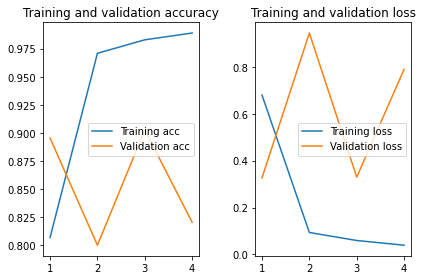

In [ ]:

from keras.callbacks import ModelCheckpoint

#path creation
base_filename='ResNet34_best_weight'
filename_suffix = 'hdf5'
k=1
learning_rate=[0.0001, 0.0005, 0.001]
batch_size=[16, 32, 48]

for i in (learning_rate):
    for j in (batch_size):
        print("Learning rate：", i ,"& Batch size：", j)
        ResNet34_model = ResNet34(150,150,3,10)
        ResNet34_model.compile(optimizer=Adam(lr=i, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss = 'categorical_crossentropy',metrics=['accuracy'])
        tStart = time.time()#計時開始
## save best model

        number = str(k)
        filepath=os.path.join(base_filename + number + "." + filename_suffix)
        early_stop  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        hist_ResNet34=ResNet34_model.fit(X_train,y_train_one,batch_size=j,epochs=10,validation_split=0.2, callbacks=[early_stop, checkpoint], verbose=1)
        tEnd = time.time()#計時結束
        k+=1
        print("Training Time :",tEnd-tStart,"\n")
        
        scores = ResNet34_model.evaluate(X_test,y_test_one,verbose=1)
        
        acc = hist_ResNet34.history['accuracy']
        val_acc = hist_ResNet34.history['val_accuracy']
        loss = hist_ResNet34.history['loss']
        val_loss = hist_ResNet34.history['val_loss']
        epochs = range(1, len(acc) + 1)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        

## Confusion Matrix

Accuracy 0.989520624303233
Confusion matrix


(<Figure size 648x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f39f0041910>)

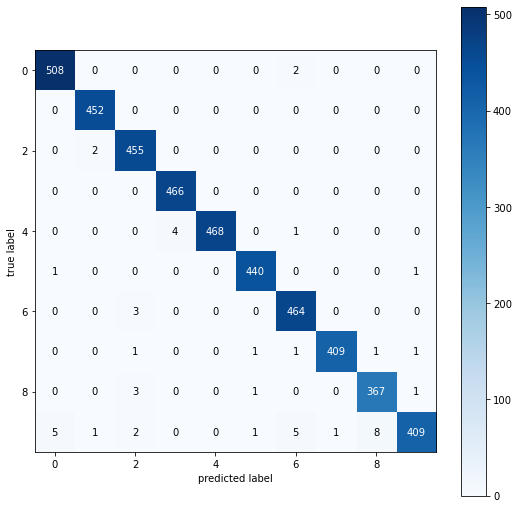

In [ ]:
best_model = tf.keras.models.load_model('ResNet34_best_weight4.hdf5')
y_pr=best_model.predict(X_test)
y_pred=[]
for i in range(len(y_pr)):
  y_pred.append(np.argmax(y_pr[i]))

cm=confusion_matrix(y_test,y_pred)
ac=accuracy_score(y_test,y_pred)
print("Accuracy", ac)
print("Confusion matrix")
plot_confusion_matrix(cm,figsize=(9,9),colorbar=True)

## Filter and Feature Observation

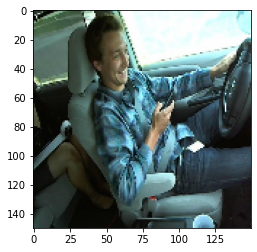

In [ ]:
img = X_test[0]
plt.imshow(img)
plt.grid(False)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [ ]:
'''
model = Model(inputs=VGG16_model, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
'''
layer_outputs = [layer.output for layer in ResNet34_model.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=ResNet34_model.input, outputs=layer_outputs)
activations = activation_model.predict(x)
#first_conv_activation = activations[1]

def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    n_row = 8
    n_column = layer_activation.shape[-1]//n_row
    
    f, ax = plt.subplots(n_row, n_column)
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            ax[i, j].imshow(channel_image,)
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

Feature_map with 1 convolution layer


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


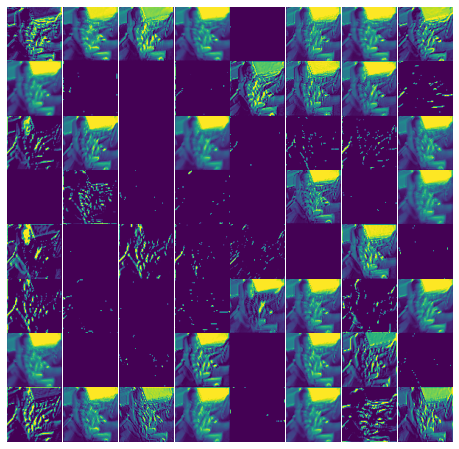

Feature_map with 2 convolution layer


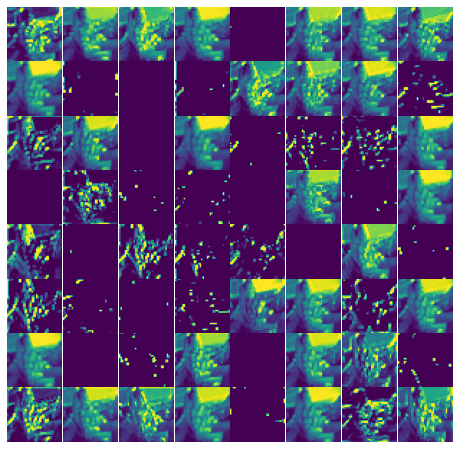

Feature_map with 3 convolution layer


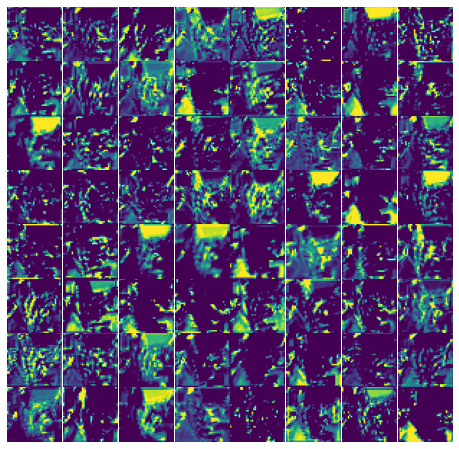

Feature_map with 8 convolution layer


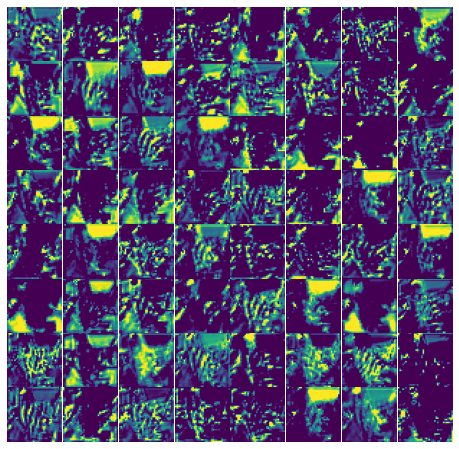

Feature_map with 10 convolution layer


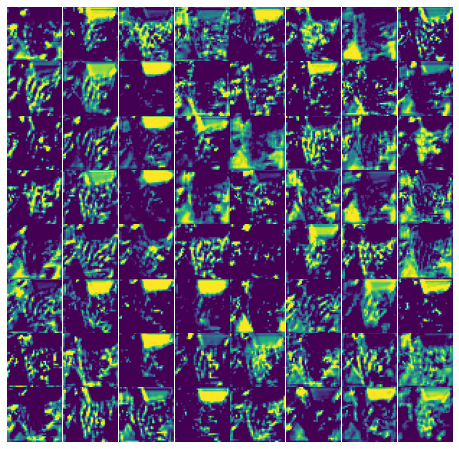

In [ ]:
for i in (1, 2, 3, 8, 10):
    print(f'Feature_map with {i} convolution layer')
    plot_activations(i, activations)